# Notebook3: Predicting CO2 emissions using Neural Networks in Design Phase

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [71]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [72]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Plot Functions

In [73]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation and Feature Selection

In [74]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [75]:
# Import data
trainset_df = pd.read_csv('Dataset2_train.csv')
testset_df = pd.read_csv('Dataset2_test.csv')

X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']


In [76]:
X_test

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,Vehicle Class_MID-SIZE,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,6.2,8.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.6,6.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.2,8.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2.0,4.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.8,4.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Setup pipline for Standardisation

In [77]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [78]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [79]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571             1.0   
1       -0.567895  -0.889172     -0.750938             1.0   
2       -0.863042  -0.889172      0.952329             1.0   
3       -0.494109  -0.889172     -0.750938             1.0   
4        1.350555   1.290448      0.952329             1.0   

   Model Features_Flexible-fuel vehicle  Model Features_Four-wheel drive  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3                                   0.0                              0.0   
4                                   0.0                              0.0   

   Model Features_Long wheelbase  Model Features_Short wheelbase  \
0                            0.0                             0.0   
1        

In [80]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_Loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



## 3 W&B Grid Search to Find Best NN Parameter Set

In [81]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [82]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [83]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [84]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [85]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [86]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage2', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        val_loss = val_epoch(model, val_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0



            torch.save(model.state_dict(), "best_model.pth")
            wandb.save("best_model.pth")  # 确保 W&B 也记录该文件



        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


epoch,▁█
epoch,2
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Epoch 001 | Train Loss: nan | Val Loss: nan
Epoch 002 | Train Loss: nan | Val Loss: nan
Epoch 003 | Train Loss: nan | Val Loss: nan
Epoch 004 | Train Loss: nan | Val Loss: nan
Epoch 005 | Train Loss: nan | Val Loss: nan
Early stopping triggered at epoch 5


epoch,▁▃▅▆█
epoch,5
train_loss,nan
val_loss,nan


Training complete for all configurations.


Visualization of each Search

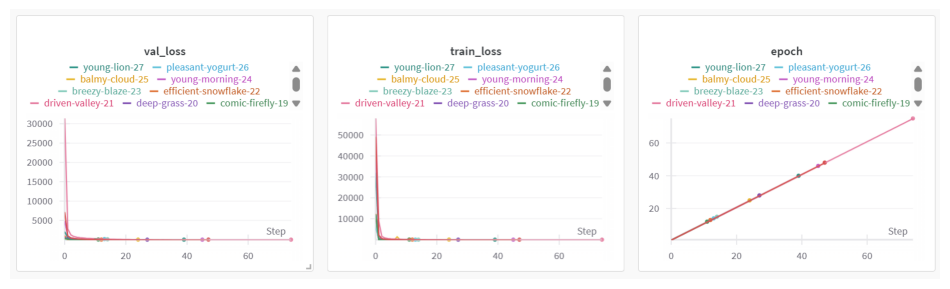

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "S1_NN_loss.png"
img = mpimg.imread(image_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [88]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

### Save all the model config

In [89]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


### Select the best model

In [90]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")




Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


## Conclusion

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 118\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




## Best Model Using K-fold Validation 

## 1 Cross-validation with different machine learning techniques


#### Import K-fold Cross-validation Method

In [91]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

### 1.1 Linear Regression Model

Train the model and Use k-fold validation, using `sklearn.linear_model` package.

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Save MSE and True/Predict Values---------------------------
lr_k_fold_mse = []
lr_k_fold_R2 = []
lr_k_fold_mae = []
lr_k_fold_mape = []

print(f'Linear Regression Model:\n')
# Train and Validate the model----------------------------
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):
    
    X_train_fold, X_val_fold = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and train the model
    lr_model = LinearRegression()
    lr_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = lr_model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    lr_k_fold_mse.append(mse)
    lr_k_fold_R2.append(r2)
    lr_k_fold_mae.append(mae)
    lr_k_fold_mape.append(mape)

    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(lr_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Linear Regression Model:



ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Test and Visualization of the Prediction / True Value

Linear Regression Model:
    Test Dataset MSE: 21.5307
    Test Dataset R2: 0.9935
    Test Dataset MAE: 2.8791
    Test Dataset MAPE: 0.0117


Text(0.5, 1.0, 'Linear Regression Model: Observed vs Predicted values')

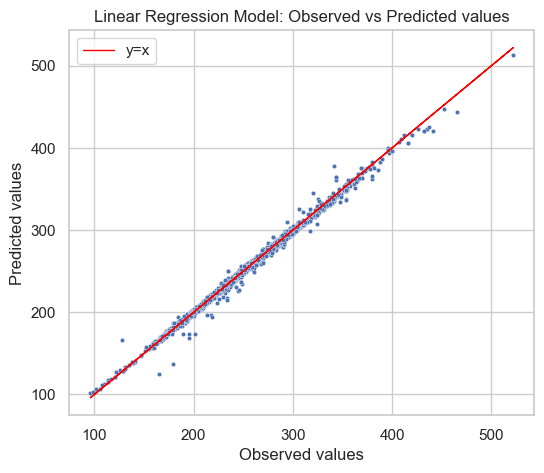

In [ ]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
lr_test_pred = lr_model.predict(X_test_df)

lr_test_r2 = r2_score(lr_test_pred, y_test)
lr_test_mse = mean_squared_error(lr_test_pred, y_test)
lr_test_mae = mean_absolute_error(lr_test_pred, y_test)
lr_test_mape = mean_absolute_percentage_error(lr_test_pred, y_test)

# Output
print(f'Linear Regression Model:')
print(f"    Test Dataset MSE: {lr_test_mse:.4f}")
print(f"    Test Dataset R2: {lr_test_r2:.4f}")
print(f"    Test Dataset MAE: {lr_test_mae:.4f}")
print(f"    Test Dataset MAPE: {lr_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, lr_test_pred, ax)
plt.title('Linear Regression Model: Observed vs Predicted values')

In [ ]:
print(f"Test Dataset MSE: {lr_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(lr_k_fold_mse):.4f}")

Test Dataset MSE: 21.5307
Validation Dataset MSE: 28.1498


### 1.2 Neural Network Model

From the previous coursework, identify the best Neural Network is `MultiLayerPercepton`. And from the results from WandB, the best hyperparameters are as follows:

- **hidden layer**: 4

- **hidden size**: 128

- **learning rate**: 0.001

So in this coursework, for Neural Network Model, `MutliLayerPercepton` is selected as the optimal model.

In [ ]:
class NN_MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(NN_MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
from torch.utils.data import Subset
from torch import optim

# Training Hyperparameters-------------------
num_epochs = 100
batch_size = 64

# Model Hyperparameters ----------------
input_dim = X_train_df.shape[1]  # input dimension
hidden_layer = 4
hidden_size = 128
learning_rate = 0.001

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset , batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = NN_MultiLayerPerceptron(input_dim, hidden_size, hidden_layer).to(device)
    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    # concatenate the true and predicted values
    # nn_all_y_true.append(np.concatenate(y_true_fold, axis=0))
    # nn_all_y_pred.append(np.concatenate(y_pred_fold, axis=0))
    
    # avg_val_loss = val_loss / len(val_loader)
    # nn_k_fold_mse.append(avg_val_loss)

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")

Neural Network Model:

Fold 1 Validation Dataset MSE: 12.0051
Fold 2 Validation Dataset MSE: 14.3170
Fold 3 Validation Dataset MSE: 8.4938
Fold 4 Validation Dataset MSE: 8.1029
Fold 5 Validation Dataset MSE: 9.1560
Fold 6 Validation Dataset MSE: 10.1916
Fold 7 Validation Dataset MSE: 7.5751
Fold 8 Validation Dataset MSE: 6.9793
Fold 9 Validation Dataset MSE: 11.2304
Fold 10 Validation Dataset MSE: 8.2312
Fold 11 Validation Dataset MSE: 6.2675
Fold 12 Validation Dataset MSE: 8.4546
Fold 13 Validation Dataset MSE: 8.9215
Fold 14 Validation Dataset MSE: 9.1330
Fold 15 Validation Dataset MSE: 11.2724
Fold 16 Validation Dataset MSE: 8.7423
Fold 17 Validation Dataset MSE: 9.9125
Fold 18 Validation Dataset MSE: 12.6421
Fold 19 Validation Dataset MSE: 8.9591
Fold 20 Validation Dataset MSE: 15.7812

K-Fold Average MSE: 9.8184

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 17.0788
    Test Dataset R2: 0.9950
    Test Dataset MAE: 3.1664
    Test Dataset MAPE: 0.0132


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

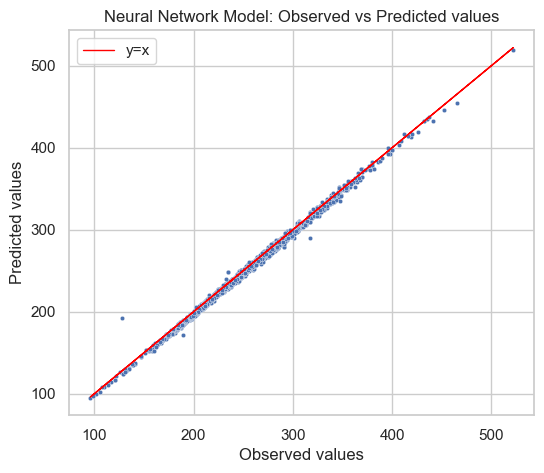

In [ ]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_Loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [ ]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 17.0788
Validation Dataset MSE: 9.8184


### 1.3 Decision Tree Model

Use decision Tree Model to predict the CO2 emission. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Save MSE and True/Predict Values---------------------------
dt_k_fold_mse = []
dt_k_fold_R2 = []
dt_k_fold_mae = []
dt_k_fold_mape = []

# Train and Evaluate the model----------------------------
print(f'Decision Tree Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):
    
    X_train_fold, X_val_fold = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and train the model
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = dt_model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    dt_k_fold_mse.append(mse)
    dt_k_fold_R2.append(r2)
    dt_k_fold_mae.append(mae)
    dt_k_fold_mape.append(mape)

    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(dt_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Decision Tree Model:

Fold 1 Validation Dataset MSE: 9.3319
Fold 2 Validation Dataset MSE: 8.5932
Fold 3 Validation Dataset MSE: 8.4441
Fold 4 Validation Dataset MSE: 8.8572
Fold 5 Validation Dataset MSE: 6.9552
Fold 6 Validation Dataset MSE: 11.3388
Fold 7 Validation Dataset MSE: 7.8194
Fold 8 Validation Dataset MSE: 8.0127
Fold 9 Validation Dataset MSE: 8.8874
Fold 10 Validation Dataset MSE: 30.2845
Fold 11 Validation Dataset MSE: 6.2967
Fold 12 Validation Dataset MSE: 7.3840
Fold 13 Validation Dataset MSE: 6.7587
Fold 14 Validation Dataset MSE: 7.4935
Fold 15 Validation Dataset MSE: 9.2731
Fold 16 Validation Dataset MSE: 9.4797
Fold 17 Validation Dataset MSE: 8.6833
Fold 18 Validation Dataset MSE: 6.1342
Fold 19 Validation Dataset MSE: 8.4474
Fold 20 Validation Dataset MSE: 10.2950

K-Fold Average MSE: 9.4385

--------Finished training and validating the model!--------


Decision Tree Model:
    Test Dataset MSE: 12.6142
    Test Dataset R2: 0.9963
    Test Dataset MAE: 1.6717
    Test Dataset MAPE: 0.0069


Text(0.5, 1.0, 'Decision Tree Model: Observed vs Predicted values')

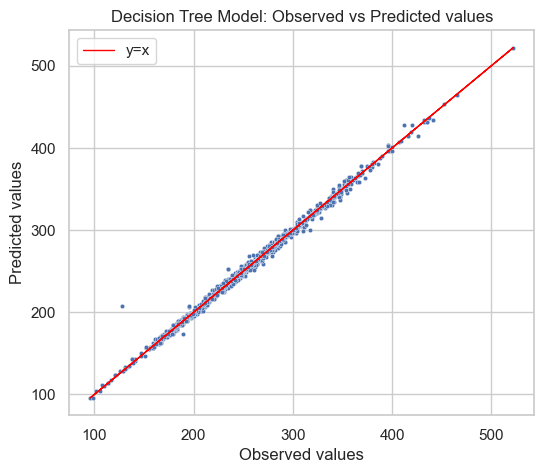

In [ ]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
dt_test_pred = dt_model.predict(X_test_df)

dt_test_r2 = r2_score(dt_test_pred, y_test)
dt_test_mse = mean_squared_error(dt_test_pred, y_test)
dt_test_mae = mean_absolute_error(dt_test_pred, y_test)
dt_test_mape = mean_absolute_percentage_error(dt_test_pred, y_test)

# Output
print(f'Decision Tree Model:')
print(f"    Test Dataset MSE: {dt_test_mse:.4f}")
print(f"    Test Dataset R2: {dt_test_r2:.4f}")
print(f"    Test Dataset MAE: {dt_test_mae:.4f}")
print(f"    Test Dataset MAPE: {dt_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, dt_test_pred, ax)
plt.title('Decision Tree Model: Observed vs Predicted values')

In [ ]:
# Inspect some values
# print(f"{dt_k_fold_mse}")
# print(f"{dt_test_mse}")

print(f"Test Dataset MSE: {dt_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(dt_k_fold_mse):.4f}")

print(f"Test Dataset R2: {dt_test_r2:.4f}")
print(f"Validation Dataset R2: {np.mean(dt_k_fold_R2):.4f}")

print(f"Test Dataset MAE: {dt_test_mae:.4f}")
print(f"Validation Dataset MAE: {np.mean(dt_k_fold_mae):.4f}")

print(f"Test Dataset MAPE: {dt_test_mape:.4f}")
print(f"Validation Dataset MAPRE: {np.mean(dt_k_fold_mape):.4f}")

Test Dataset MSE: 12.6142
Validation Dataset MSE: 9.4385
Test Dataset R2: 0.9963
Validation Dataset R2: 0.9972
Test Dataset MAE: 1.6717
Validation Dataset MAE: 1.6526
Test Dataset MAPE: 0.0069
Validation Dataset MAPRE: 0.0067


### 1.4 PCA Based Regression Model

From previous coursework, I analysed the Regression model based on selected PCA conponents, and find the best model is to use all the PCA conponents. 
But in the previous coursework, the categorical variables are not encoded and included in the PCA analysis. So PCA conponent based regression model should be finetuned to select the optimal model.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pca = PCA() # n_components=0.95
scaler_pca = StandardScaler()

# Save MSE and True/Predict Values---------------------------
pca_k_fold_mse = []
pca_k_fold_R2 = []
pca_k_fold_mae = []
pca_k_fold_mape = []

# Train and Evaluate the model----------------------------
print(f'PCA Based Regression Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    X_train_fold, X_val_fold = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Perform PCA on the training dataset
    X_train_pca = pca.fit_transform(X_train_fold)
    X_val_pca = pca.transform(X_val_fold)

    # Select all the conponents (exclue the last two components)
    X_train_pca_select = X_train_pca[:, :-2]
    X_val_pca_select = X_val_pca[:, :-2]

    # X_train_pca_select = X_train_pca
    # X_val_pca_select = X_val_pca

    # Fit the linear regression model
    pca_lr_model = LinearRegression()
    pca_lr_model.fit(X_train_pca_select, y_train_fold)

    y_pred_fold = pca_lr_model.predict(X_val_pca_select)
    
    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    pca_k_fold_mse.append(mse)
    pca_k_fold_R2.append(r2)
    pca_k_fold_mae.append(mae)
    pca_k_fold_mape.append(mape)

    print(f"Fold {fold + 1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(pca_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


PCA Based Regression Model:

Fold 1 Validation Dataset MSE: 17.5194
Fold 2 Validation Dataset MSE: 31.8510
Fold 3 Validation Dataset MSE: 19.1056
Fold 4 Validation Dataset MSE: 20.7628
Fold 5 Validation Dataset MSE: 22.4198
Fold 6 Validation Dataset MSE: 46.1904
Fold 7 Validation Dataset MSE: 38.3613
Fold 8 Validation Dataset MSE: 23.2841
Fold 9 Validation Dataset MSE: 37.6981
Fold 10 Validation Dataset MSE: 57.4788
Fold 11 Validation Dataset MSE: 26.2257
Fold 12 Validation Dataset MSE: 16.7673
Fold 13 Validation Dataset MSE: 15.5130
Fold 14 Validation Dataset MSE: 17.6877
Fold 15 Validation Dataset MSE: 26.3558
Fold 16 Validation Dataset MSE: 31.4551
Fold 17 Validation Dataset MSE: 28.6512
Fold 18 Validation Dataset MSE: 30.6938
Fold 19 Validation Dataset MSE: 16.4837
Fold 20 Validation Dataset MSE: 38.4916

K-Fold Average MSE: 28.1498

--------Finished training and validating the model!--------


Decision Tree Model:
    Test Dataset MSE: 21.5307
    Test Dataset R2: 0.9935
    Test Dataset MAE: 2.8791
    Test Dataset MAPE: 0.0117


Text(0.5, 1.0, 'PCA Based Regression Model: Observed vs Predicted values')

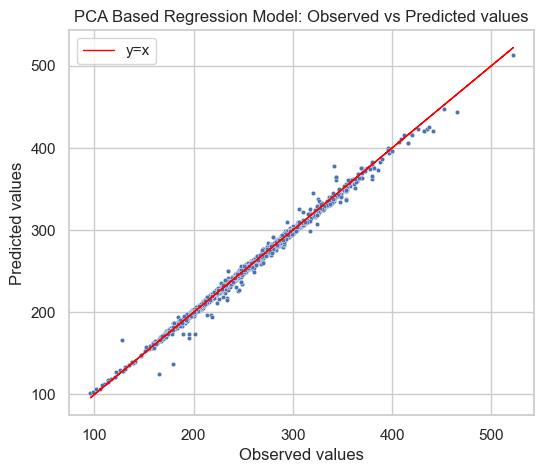

In [ ]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE

# X_test_pca = pca.transform(X_test_df)
X_test_pca = pca.transform(X_test_df)[:, :-2]

pca_test_pred = pca_lr_model.predict(X_test_pca)

pca_test_r2 = r2_score(pca_test_pred, y_test)
pca_test_mse = mean_squared_error(pca_test_pred, y_test)
pca_test_mae = mean_absolute_error(pca_test_pred, y_test)
pca_test_mape = mean_absolute_percentage_error(pca_test_pred, y_test)

# Output
print(f'Decision Tree Model:')
print(f"    Test Dataset MSE: {pca_test_mse:.4f}")
print(f"    Test Dataset R2: {pca_test_r2:.4f}")
print(f"    Test Dataset MAE: {pca_test_mae:.4f}")
print(f"    Test Dataset MAPE: {pca_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, pca_test_pred, ax)
plt.title('PCA Based Regression Model: Observed vs Predicted values')

In [ ]:
# Inspect some values
print(f"{pca_k_fold_mse}")
print(f"{pca_test_mse}")
print(f"PCA component shape: {X_train_pca_select.shape}")

print(f"Test Dataset MSE: {pca_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(pca_k_fold_mse):.4f}")

[17.519404585720967, 31.85099397892638, 19.105647748779393, 20.762829508359225, 22.419833763075776, 46.190350214729165, 38.361336550387456, 23.28412406893701, 37.698064081775556, 57.47884179867971, 26.22570258385282, 16.767326225405988, 15.512997830883364, 17.687679807202002, 26.355767466261625, 31.455137030235655, 28.65116475384985, 30.693846969149973, 16.4836977014868, 38.49162483832732]
21.53070569791022
PCA component shape: (5613, 51)
Test Dataset MSE: 21.5307
Validation Dataset MSE: 28.1498
